In [1]:
with open('AzureFunctionsInvocationTraceForTwoWeeksJan2021.txt', 'r') as source:
    with open('AzureFunctionsInvocationTraceForTwoWeeksJan2021.csv', 'w') as target:
        target.write(source.read())
        
        

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import plotly.graph_objects as go
import seaborn as sns
import plotly.express as px
import datetime
plt.rcParams['figure.figsize'] = (50, 20) 

In [2]:
df = pd.read_csv("./AzureFunctionsInvocationTraceForTwoWeeksJan2021.csv")
df['time'] = [datetime.datetime(2021,1,31) + datetime.timedelta(seconds=x) for x in df['end_timestamp']]

In [10]:
df.head()

,app,func,end_timestamp,duration,time
0,7b2c43a2bc30f6bb438074df88b603d2cb982d3e7961de...,e3cdb48830f66eb8689cc0223514569a69812b77e6611e...,0.079491,0.078,2021-01-31 00:00:00.079491
1,1573b95c039e51cc012b543a4af3bc7c3ee9485acbb003...,337cd24a7d5fd5c92460faee4ebe6a186a0eb322bd17b7...,57.157860,57.154,2021-01-31 00:00:57.157860
2,1573b95c039e51cc012b543a4af3bc7c3ee9485acbb003...,48cc770d590d3c5a7691b3b4e9302f82ec3be5ddc2a037...,59.130478,59.125,2021-01-31 00:00:59.130478
3,f274d71de386ccc77e4ca74766dbc485461c3053059d47...,3d2aee54a133509f16fb636d74128c2adcfcac71c6dcef...,6.252541,6.236,2021-01-31 00:00:06.252541
4,7b2c43a2bc30f6bb438074df88b603d2cb982d3e7961de...,68bbfd828223a505d7917339f4656c5f33ff93225cdb9d...,0.066824,0.050,2021-01-31 00:00:00.066824


Fitting ARIMA model...


/home/ss6928/.conda/envs/new_env_name/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



RMSE: 28.1519


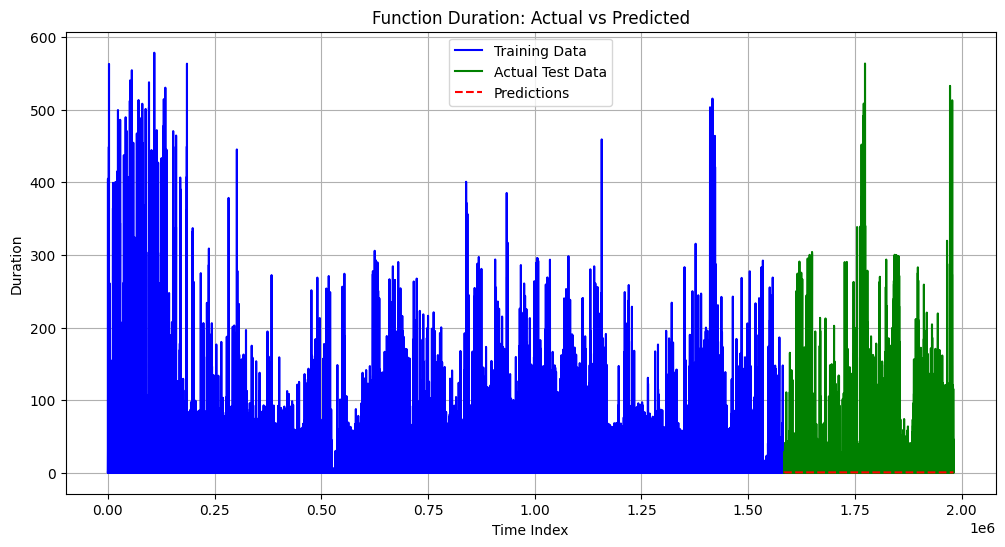

In [8]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

def load_and_prepare_data(file_path):
    df = pd.read_csv(file_path)
    df['duration'] = pd.to_numeric(df['duration'])
    df = df.sort_values('end_timestamp')
    
    # Scale the duration data
    scaler = StandardScaler()
    df['duration_scaled'] = scaler.fit_transform(df['duration'].values.reshape(-1, 1))
    
    return df, scaler

def train_test_split(data, train_size=0.8):
    train_size = int(len(data) * train_size)
    train = data[:train_size]
    test = data[train_size:]
    return train, test

def fit_arima(train_data):
    model = ARIMA(train_data, order=(2,1,2)) 
    results = model.fit()
    return results

def plot_results(train_data, test_data, predictions):
    plt.figure(figsize=(12, 6))
    plt.plot(range(len(train_data)), train_data, label='Training Data', color='blue')
    plt.plot(range(len(train_data), len(train_data) + len(test_data)), 
             test_data, label='Actual Test Data', color='green')
    plt.plot(range(len(train_data), len(train_data) + len(test_data)), 
             predictions, label='Predictions', color='red', linestyle='--')
    plt.title('Function Duration: Actual vs Predicted')
    plt.xlabel('Time Index')
    plt.ylabel('Duration')
    plt.legend()
    plt.grid(True)
    plt.show()

def main():
    df, scaler = load_and_prepare_data('AzureFunctionsInvocationTraceForTwoWeeksJan2021.csv')
    
    duration_series_scaled = df['duration_scaled'].values
    
    train_data, test_data = train_test_split(duration_series_scaled, train_size=0.8)
    
    print("Fitting ARIMA model...")
    model = fit_arima(train_data)
    
    predictions_scaled = model.forecast(steps=len(test_data))
    
    predictions = scaler.inverse_transform(predictions_scaled.reshape(-1, 1)).flatten()
    test_data_original = scaler.inverse_transform(test_data.reshape(-1, 1)).flatten()
    train_data_original = scaler.inverse_transform(train_data.reshape(-1, 1)).flatten()
    
    rmse = np.sqrt(mean_squared_error(test_data_original, predictions))
    print(f"\nRMSE: {rmse:.4f}")
    
    plot_results(train_data_original, test_data_original, predictions)
    
    return model, predictions

if __name__ == "__main__":
    model, predictions = main()

/home/ss6928/.conda/envs/new_env_name/lib/python3.10/site-packages/xgboost/core.py:265: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc 2.28+) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(


Fitting XGBoost model...

RMSE: 19.6854


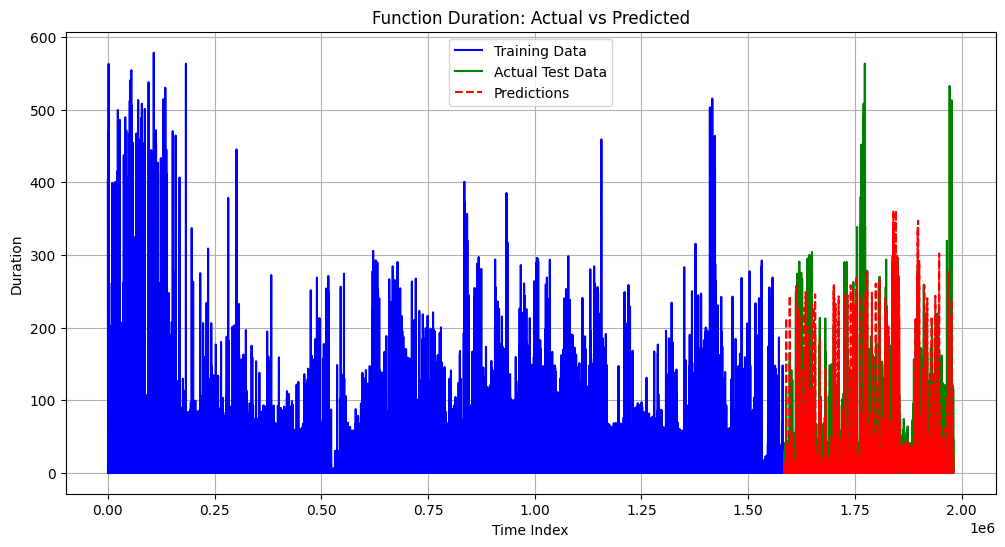


Feature Importance:
         feature  importance
2  duration_lag1    0.610829
3  duration_lag2    0.214548
4  duration_lag3    0.111093
0           hour    0.032379
1            day    0.031150


In [5]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

def load_and_prepare_data(file_path):
    df = pd.read_csv(file_path)
    
    df['end_timestamp'] = pd.to_numeric(df['end_timestamp'])
    df['duration'] = pd.to_numeric(df['duration'])
    
    df['hour'] = df['end_timestamp'] % 24
    df['day'] = (df['end_timestamp'] // 24) % 7
    
    # Create lag features
    df['duration_lag1'] = df['duration'].shift(1)
    df['duration_lag2'] = df['duration'].shift(2)
    df['duration_lag3'] = df['duration'].shift(3)
    
    df = df.dropna()
    
    return df

def train_test_split(df, train_size=0.8):
    train_size = int(len(df) * train_size)
    
    features = ['hour', 'day', 'duration_lag1', 'duration_lag2', 'duration_lag3']
    
    X_train = df[features][:train_size]
    y_train = df['duration'][:train_size]
    
    X_test = df[features][train_size:]
    y_test = df['duration'][train_size:]
    
    return X_train, X_test, y_train, y_test

def fit_xgboost(X_train, y_train):
    model = xgb.XGBRegressor(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=5,
        random_state=42
    )
    model.fit(X_train, y_train)
    return model

def make_predictions(model, X_test):

    predictions = model.predict(X_test)

    predictions = np.maximum(predictions, 0)
    return predictions

def plot_results(train_data, test_data, predictions):
    plt.figure(figsize=(12, 6))
    plt.plot(range(len(train_data)), train_data, label='Training Data', color='blue')
    plt.plot(range(len(train_data), len(train_data) + len(test_data)), 
             test_data, label='Actual Test Data', color='green')
    plt.plot(range(len(train_data), len(train_data) + len(test_data)), 
             predictions, label='Predictions', color='red', linestyle='--')
    plt.title('Function Duration: Actual vs Predicted')
    plt.xlabel('Time Index')
    plt.ylabel('Duration')
    plt.legend()
    plt.grid(True)
    plt.show()

def main():

    df = load_and_prepare_data('AzureFunctionsInvocationTraceForTwoWeeksJan2021.csv')
    

    X_train, X_test, y_train, y_test = train_test_split(df)
    
    print("Fitting XGBoost model...")
    model = fit_xgboost(X_train, y_train)
    

    predictions = make_predictions(model, X_test)
    

    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    print(f"\nRMSE: {rmse:.4f}")
    

    plot_results(y_train, y_test, predictions)
    

    importance = pd.DataFrame({
        'feature': X_train.columns,
        'importance': model.feature_importances_
    })
    print("\nFeature Importance:")
    print(importance.sort_values('importance', ascending=False))
    
    return model, predictions

if __name__ == "__main__":
    model, predictions = main()

Using device: cuda
Training Transformer model...
Epoch [1/10], Train Loss: 0.6382, Val Loss: 0.2337
Epoch [2/10], Train Loss: 0.5769, Val Loss: 0.2339
Epoch [3/10], Train Loss: 0.5710, Val Loss: 0.2327
Epoch [4/10], Train Loss: 0.5690, Val Loss: 0.2337
Epoch [5/10], Train Loss: 0.5675, Val Loss: 0.2330
Epoch [6/10], Train Loss: 0.5670, Val Loss: 0.2342
Epoch [7/10], Train Loss: 0.5658, Val Loss: 0.2335
Epoch [8/10], Train Loss: 0.5649, Val Loss: 0.2337
Epoch [9/10], Train Loss: 0.5644, Val Loss: 0.2335
Epoch [10/10], Train Loss: 0.5641, Val Loss: 0.2326


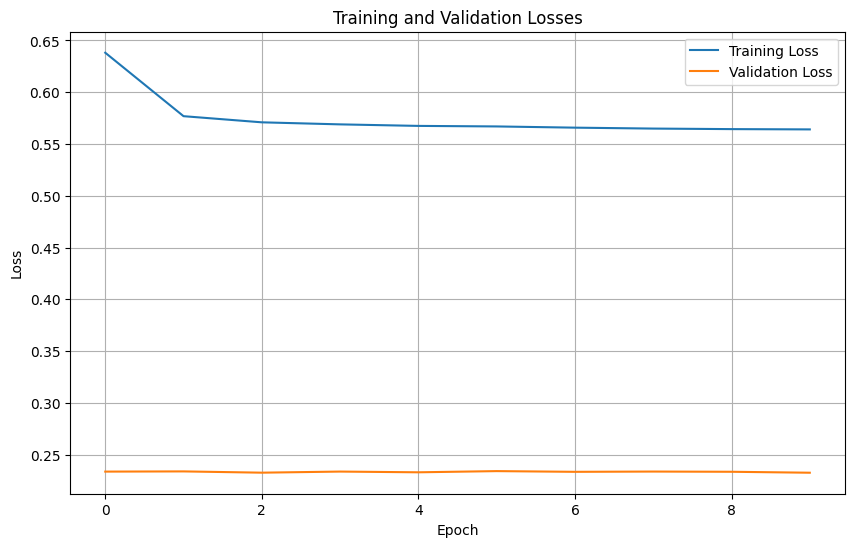


Test RMSE: 16.6755


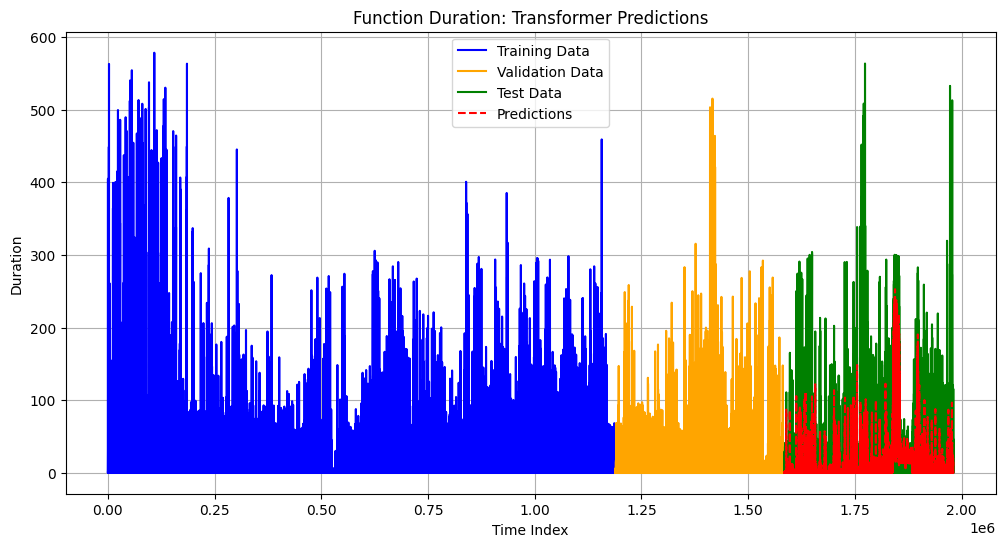

In [16]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

class TimeSeriesTransformer(nn.Module):
    def __init__(self, input_dim, seq_len, num_layers=2, nhead=2, dim_feedforward=128):
        super().__init__()
        
        self.embedding = nn.Linear(input_dim, 8)
        self.pos_encoder = nn.Linear(seq_len, seq_len)
        
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=8,
            nhead=2,
            dim_feedforward=dim_feedforward,
            batch_first=True
        )
        
        self.transformer_encoder = nn.TransformerEncoder(
            encoder_layer,
            num_layers=num_layers
        )
        
        self.decoder = nn.Linear(8, 1)
        
    def forward(self, x):
        x = self.embedding(x)
        x = self.transformer_encoder(x)
        x = self.decoder(x)
        return x

class TimeSeriesDataset(Dataset):
    def __init__(self, data, seq_length):
        self.data = torch.FloatTensor(data).to(device)
        self.seq_length = seq_length
        
    def __len__(self):
        return len(self.data) - self.seq_length
        
    def __getitem__(self, idx):
        sequence = self.data[idx:idx+self.seq_length]
        target = self.data[idx+1:idx+self.seq_length+1]
        return sequence.reshape(-1, 1), target.reshape(-1, 1)

def evaluate_model(model, data_loader, criterion):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for src, tgt in data_loader:
            output = model(src)
            loss = criterion(output, tgt)
            total_loss += loss.item()
    return total_loss / len(data_loader)

def train_model(model, train_loader, val_loader, num_epochs=10, learning_rate=0.001):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()
    
    train_losses = []
    val_losses = []
    
    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0
        
        for src, tgt in train_loader:
            optimizer.zero_grad()
            output = model(src)
            loss = criterion(output, tgt)
            loss.backward()
            optimizer.step()
            
            total_train_loss += loss.item()
        
        avg_train_loss = total_train_loss / len(train_loader)
        avg_val_loss = evaluate_model(model, val_loader, criterion)
        
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')
    
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Training and Validation Losses')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return train_losses, val_losses

def make_predictions(model, test_data, seq_length):
    model.eval()
    predictions = []
    
    with torch.no_grad():
        for i in range(len(test_data) - seq_length):
            sequence = torch.FloatTensor(test_data[i:i+seq_length]).reshape(1, -1, 1).to(device)
            pred = model(sequence)
            predictions.append(pred[0, -1, 0].cpu().item())
    
    return np.array(predictions)

def plot_results(train_data, val_data, test_data, predictions):
    plt.figure(figsize=(12, 6))
    plt.plot(range(len(train_data)), train_data, label='Training Data', color='blue')
    plt.plot(range(len(train_data), len(train_data) + len(val_data)), 
             val_data, label='Validation Data', color='orange')
    plt.plot(range(len(train_data) + len(val_data), 
             len(train_data) + len(val_data) + len(test_data)), 
             test_data, label='Test Data', color='green')
    plt.plot(range(len(train_data) + len(val_data), 
             len(train_data) + len(val_data) + len(predictions)), 
             predictions, label='Predictions', color='red', linestyle='--')
    plt.title('Function Duration: Transformer Predictions')
    plt.xlabel('Time Index')
    plt.ylabel('Duration')
    plt.legend()
    plt.grid(True)
    plt.show()
    
def load_and_prepare_data(file_path, seq_length=10):
    df = pd.read_csv(file_path)
    df['duration'] = pd.to_numeric(df['duration'])
    df = df.sort_values('end_timestamp')
    
    scaler = StandardScaler()
    duration_scaled = scaler.fit_transform(df['duration'].values.reshape(-1, 1))
    
    return duration_scaled, scaler


seq_length = 50
batch_size = 1024
input_dim = 1

data, scaler = load_and_prepare_data('AzureFunctionsInvocationTraceForTwoWeeksJan2021.csv', seq_length)

train_size = int(0.6 * len(data))
val_size = int(0.2 * len(data))

train_data = data[:train_size]
val_data = data[train_size:train_size + val_size]
test_data = data[train_size + val_size:]

train_dataset = TimeSeriesDataset(train_data, seq_length)
val_dataset = TimeSeriesDataset(val_data, seq_length)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

model = TimeSeriesTransformer(input_dim, seq_length).to(device)

print("Training Transformer model...")
train_losses, val_losses = train_model(model, train_loader, val_loader)

predictions = make_predictions(model, test_data, seq_length)

predictions = scaler.inverse_transform(predictions.reshape(-1, 1)).flatten()
predictions = np.maximum(predictions, 0)  # Cap at 0

train_data_original = scaler.inverse_transform(train_data)
val_data_original = scaler.inverse_transform(val_data)
test_data_original = scaler.inverse_transform(test_data)

test_data_for_comparison = test_data_original[seq_length:len(predictions) + seq_length]
rmse = np.sqrt(mean_squared_error(test_data_for_comparison, predictions))
print(f"\nTest RMSE: {rmse:.4f}")

plot_results(train_data_original, val_data_original, test_data_original[:-1], predictions)
    

